In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from collections import Counter
from transformers import BertTokenizer, BertModel, AdamW

import os


In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')
data[text_columns] = data[text_columns].fillna('')

data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')


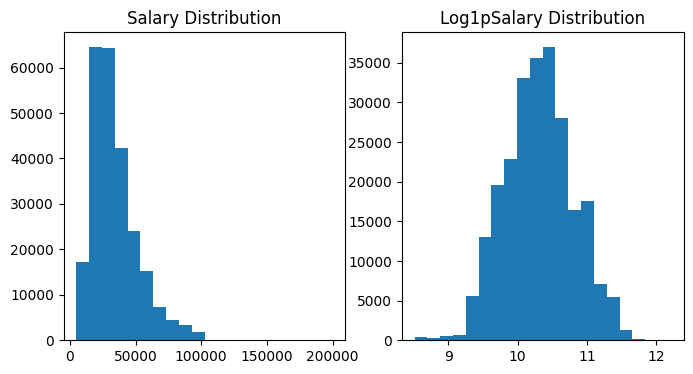

In [3]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)
plt.title('Salary Distribution')

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.title('Log1pSalary Distribution')
plt.show()


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [5]:
top_companies = data['Company'].value_counts().nlargest(1000).index
data['Company'] = data['Company'].apply(lambda x: x if x in top_companies else 'Other')

categorical_vectorizer = DictVectorizer(sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))


DictVectorizer(sparse=False)

In [6]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

print("Train size:", len(data_train))
print("Validation size:", len(data_val))


Train size: 195814
Validation size: 48954


In [7]:
class SalaryDataset(Dataset):
    def __init__(self, data, tokenizer, categorical_vectorizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.categorical_vectorizer = categorical_vectorizer
        self.max_length = max_length
        self.categorical_columns = categorical_columns
        self.text_columns = text_columns
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        
        text = item['Title'] + " " + item['FullDescription']
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        cat_features = item[self.categorical_columns].to_dict()
        cat_features_vectorized = self.categorical_vectorizer.transform([cat_features])[0]
        
        inputs = {
            'input_ids': encoding['input_ids'].squeeze(),  # Shape: [max_length]
            'attention_mask': encoding['attention_mask'].squeeze(),  # Shape: [max_length]
            'categorical_features': torch.tensor(cat_features_vectorized, dtype=torch.float32),
        }
        
        if TARGET_COLUMN in item:
            inputs['salary'] = torch.tensor(item[TARGET_COLUMN], dtype=torch.float32)
        
        return inputs


In [9]:
train_dataset = SalaryDataset(data_train, tokenizer, categorical_vectorizer)
val_dataset = SalaryDataset(data_val, tokenizer, categorical_vectorizer)

batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [10]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_cat_features, hidden_size=64, dropout_prob=0.3):
        super(SalaryPredictor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
                
        self.cat_layer = nn.Sequential(
            nn.Linear(n_cat_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        
        combined_input_size = self.bert.config.hidden_size + hidden_size
        
        self.regressor = nn.Sequential(
            nn.Linear(combined_input_size, 1)
        )
        
    def forward(self, input_ids, attention_mask, categorical_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output 
        
        cat_output = self.cat_layer(categorical_features) 
        
        combined = torch.cat((pooled_output, cat_output), dim=1)  
        
        output = self.regressor(combined)  
        
        return output.squeeze()


In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using cuda GPU")

elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using MPS")
else:
    print(f"Using CPU")
    device = torch.device('cpu')

n_cat_features = len(categorical_vectorizer.vocabulary_)
model = SalaryPredictor(n_cat_features=n_cat_features).to(device)

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)


Using cuda GPU


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def save_checkpoint(state, filename='model_checkpoint.pth'):
    torch.save(state, filename)
    print(f"Checkpoint saved at '{filename}'")

def load_checkpoint(filename='model_checkpoint.pth'):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded, starting from epoch {start_epoch}")
        return start_epoch
    else:
        print(f"No checkpoint found at '{filename}'")
        return 0


In [13]:
from tqdm import tqdm  

def train_epoch(model, data_loader, optimizer, criterion, device, epoch, num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        categorical_features = batch['categorical_features'].to(device)
        labels = batch['salary'].to(device)

        outputs = model(input_ids, attention_mask, categorical_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss

def evaluate_epoch(model, data_loader, criterion, device, epoch, num_epochs):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(data_loader, desc=f"Eval {epoch+1}/{num_epochs}", leave=False)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            categorical_features = batch['categorical_features'].to(device)
            labels = batch['salary'].to(device)  # Log1pSalary values

            outputs = model(input_ids, attention_mask, categorical_features)
            loss = criterion(outputs, labels)  # Loss in log space
            
            total_loss += loss.item() * input_ids.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(data_loader.dataset)
    mae = mean_absolute_error(all_labels, all_preds)
    return avg_loss, mae


In [ ]:
num_epochs = 20
model_save_path = 'model_checkpoint.pth'

start_epoch = load_checkpoint(model_save_path)

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_mae = evaluate_epoch(model, val_loader, criterion, device, epoch, num_epochs)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.2f}\n")
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, model_save_path)


No checkpoint found at 'model_checkpoint.pth'
Epoch 1/20


Training Loss: 1.2236


Validation Loss: 0.0731, Validation MAE: 0.20

Checkpoint saved at 'model_checkpoint.pth'
Epoch 2/20


Training Loss: 0.0627


Validation Loss: 0.0712, Validation MAE: 0.20

Checkpoint saved at 'model_checkpoint.pth'
Epoch 3/20


Training Loss: 0.0499


Validation Loss: 0.0629, Validation MAE: 0.19

Checkpoint saved at 'model_checkpoint.pth'
Epoch 4/20


Training Loss: 0.0399


Validation Loss: 0.0498, Validation MAE: 0.16

Checkpoint saved at 'model_checkpoint.pth'
Epoch 5/20


Training Loss: 0.0325


Validation Loss: 0.0611, Validation MAE: 0.19

Checkpoint saved at 'model_checkpoint.pth'
Epoch 6/20


Training Loss: 0.0261


Validation Loss: 0.0507, Validation MAE: 0.16

Checkpoint saved at 'model_checkpoint.pth'
Epoch 7/20


Training Loss: 0.0212


Validation Loss: 0.0492, Validation MAE: 0.16

Checkpoint saved at 'model_checkpoint.pth'
Epoch 8/20


Training Loss: 0.0177


Validation Loss: 0.0540, Validation MAE: 0.17

Checkpoint saved at 'model_checkpoint.pth'
Epoch 9/20


Training Loss: 0.0149


Validation Loss: 0.0487, Validation MAE: 0.16

Checkpoint saved at 'model_checkpoint.pth'
Epoch 10/20


Training Loss: 0.0128


Validation Loss: 0.0493, Validation MAE: 0.16

Checkpoint saved at 'model_checkpoint.pth'
Epoch 11/20


Training Loss: 0.0113


Validation Loss: 0.0440, Validation MAE: 0.14

Checkpoint saved at 'model_checkpoint.pth'
Epoch 12/20


Epoch 12/20:  88%|████████▊ | 2704/3060 [23:01<02:58,  1.99it/s, loss=0.0066] 

In [13]:
num_epochs = 20
model_save_path = 'model_checkpoint.pth'

start_epoch = load_checkpoint(model_save_path)

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_mae = evaluate_epoch(model, val_loader, criterion, device, epoch, num_epochs)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.2f}\n")
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, model_save_path)

Loading checkpoint 'model_checkpoint.pth'
Checkpoint loaded, starting from epoch 11
Epoch 12/20


Training Loss: 0.0104


Validation Loss: 0.0429, Validation MAE: 0.14

Checkpoint saved at 'model_checkpoint.pth'
Epoch 13/20


Training Loss: 0.0093


Validation Loss: 0.0416, Validation MAE: 0.14

Checkpoint saved at 'model_checkpoint.pth'
Epoch 14/20


Training Loss: 0.0085


Validation Loss: 0.0419, Validation MAE: 0.14

Checkpoint saved at 'model_checkpoint.pth'
Epoch 15/20


Training Loss: 0.0077


Validation Loss: 0.0435, Validation MAE: 0.14

Checkpoint saved at 'model_checkpoint.pth'
Epoch 16/20


Training Loss: 0.0073


Validation Loss: 0.0435, Validation MAE: 0.14

Checkpoint saved at 'model_checkpoint.pth'
Epoch 17/20


Training Loss: 0.0067


Validation Loss: 0.0417, Validation MAE: 0.13

Checkpoint saved at 'model_checkpoint.pth'
Epoch 18/20


Training Loss: 0.0064


Validation Loss: 0.0441, Validation MAE: 0.14

Checkpoint saved at 'model_checkpoint.pth'
Epoch 19/20


Training Loss: 0.0060


Validation Loss: 0.0401, Validation MAE: 0.13

Checkpoint saved at 'model_checkpoint.pth'
Epoch 20/20


Training Loss: 0.0057


Validation Loss: 0.0408, Validation MAE: 0.13

Checkpoint saved at 'model_checkpoint.pth'


In [ ]:
num_epochs = 30
model_save_path = 'model_checkpoint.pth'

start_epoch = load_checkpoint(model_save_path)

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_mae = evaluate_epoch(model, val_loader, criterion, device, epoch, num_epochs)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.5f}\n")
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, model_save_path)

Loading checkpoint 'model_checkpoint.pth'
Checkpoint loaded, starting from epoch 20
Epoch 21/30


Training Loss: 0.0055


Validation Loss: 0.0402, Validation MAE: 0.13010

Checkpoint saved at 'model_checkpoint.pth'
Epoch 22/30


Training Loss: 0.0052


Validation Loss: 0.0401, Validation MAE: 0.12946

Checkpoint saved at 'model_checkpoint.pth'
Epoch 23/30


Epoch 23/30:   2%|▏         | 53/3060 [00:26<25:07,  1.99it/s, loss=0.00299]

In [ ]:
num_epochs = 30
model_save_path = 'model_checkpoint.pth'

start_epoch = load_checkpoint(model_save_path)

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_mae = evaluate_epoch(model, val_loader, criterion, device, epoch, num_epochs)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.5f}\n")
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, model_save_path)

Loading checkpoint 'model_checkpoint.pth'
Checkpoint loaded, starting from epoch 22
Epoch 23/30


Training Loss: 0.0050


Validation Loss: 0.0400, Validation MAE: 0.12954

Checkpoint saved at 'model_checkpoint.pth'
Epoch 24/30


Training Loss: 0.0048


Validation Loss: 0.0403, Validation MAE: 0.13010

Checkpoint saved at 'model_checkpoint.pth'
Epoch 25/30


Training Loss: 0.0045


Validation Loss: 0.0405, Validation MAE: 0.13073

Checkpoint saved at 'model_checkpoint.pth'
Epoch 26/30


Epoch 26/30:  11%|█         | 322/3060 [02:47<23:53,  1.91it/s, loss=0.00436]

In [14]:
num_epochs = 30
model_save_path = 'model_checkpoint.pth'

start_epoch = load_checkpoint(model_save_path)

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_mae = evaluate_epoch(model, val_loader, criterion, device, epoch, num_epochs)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.5f}\n")
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, model_save_path)

Loading checkpoint 'model_checkpoint.pth'
Checkpoint loaded, starting from epoch 25
Epoch 26/30


Training Loss: 0.0045


Validation Loss: 0.0397, Validation MAE: 0.12821

Checkpoint saved at 'model_checkpoint.pth'
Epoch 27/30


Training Loss: 0.0042


Validation Loss: 0.0397, Validation MAE: 0.12904

Checkpoint saved at 'model_checkpoint.pth'
Epoch 28/30


Training Loss: 0.0041


Validation Loss: 0.0402, Validation MAE: 0.13114

Checkpoint saved at 'model_checkpoint.pth'
Epoch 29/30


Training Loss: 0.0040


Validation Loss: 0.0387, Validation MAE: 0.12545

Checkpoint saved at 'model_checkpoint.pth'
Epoch 30/30


Training Loss: 0.0038


Validation Loss: 0.0394, Validation MAE: 0.12791

Checkpoint saved at 'model_checkpoint.pth'
